### 환경설정

In [65]:
import selenium
from selenium import webdriver as wd
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from itertools import repeat
import re
import random
import sqlite3
from pymongo import MongoClient

import matplotlib.pyplot as plt
import seaborn as sns

### 코스피200 크롤링

In [2]:
# 2018.06.04 까지 크롤링

date_list = []
price_list = []

date = '2021-06-25'
page_num = 1
while date > '2018-06-04' :
        
    # 주소 입력
    url = "https://finance.naver.com/sise/sise_index_day.nhn?code=KPI200&page="+str(page_num)
    
    page_num += 1
    
    # 차단 방지
    headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'}


    # 접속
    req = requests.get(url, headers=headers)
    source = BeautifulSoup(req.text, 'lxml')


    date_all = source.find_all('td', class_ = 'date')
    price_all = source.find_all('td', class_ = 'number_1')

    
    for j in range(len(date_all)) :
        
        date = date_all[j].text.replace('.', '-')
        price = price_all[4*j].text

        date_list.append(date)
        price_list.append(price)
        
        if date <= '2018-06-04' :
            break
            
df_KPI200_all = pd.DataFrame({"date" : date_list, "price" : price_list})    
df_KPI200_all

,date,price
0,2021-06-25,440.86
1,2021-06-24,438.38
2,2021-06-23,436.73
3,2021-06-22,434.42
4,2021-06-21,431.46
...,...,...
750,2018-06-11,317.22
751,2018-06-08,314.97
752,2018-06-07,317.67
753,2018-06-05,315.76


### 데이터 수정

In [3]:
df_KPI200 = df_KPI200_all.drop(df_KPI200_all[df_KPI200_all['date'] > '2021-06-18'].index)
df_KPI200.sort_values(by = ['date'], axis = 0, inplace = True)
df_KPI200.reset_index(inplace = True)
df_KPI200 = df_KPI200.drop(['index'], axis = 1)
df_KPI200

,date,price
0,2018-06-04,314.84
1,2018-06-05,315.76
2,2018-06-07,317.67
3,2018-06-08,314.97
4,2018-06-11,317.22
...,...,...
745,2021-06-14,433.22
746,2021-06-15,434.13
747,2021-06-16,436.96
748,2021-06-17,434.73


In [50]:
df_KPI200 = df_KPI200.astype({'price' : 'float'})

In [51]:
df_KPI200.dtypes

date      object
price    float64
dtype: object

In [91]:
# 2018-06-01 : 313.22
change_list = [round(314.84 - 313.21, 2)]
price_list = list(df_KPI200['price'].values)
for i in range(len(df_KPI200)-1) :
    change = price_list[i+1] - price_list[i]
    change_list.append(round(change, 2))
    
change_list

df_KPI200['change'] = change_list
df_KPI200

,date,price,change
0,2018-06-04,314.84,1.63
1,2018-06-05,315.76,0.92
2,2018-06-07,317.67,1.91
3,2018-06-08,314.97,-2.70
4,2018-06-11,317.22,2.25
...,...,...,...
745,2021-06-14,433.22,0.44
746,2021-06-15,434.13,0.91
747,2021-06-16,436.96,2.83
748,2021-06-17,434.73,-2.23


### 날짜 정보 크롤링

In [4]:
# 창 실행 옵션x
options = wd.ChromeOptions()
options.add_argument("headless") 

# 크롬드라이버 열기
driver = wd.Chrome('chromedriver', chrome_options=options) # 크롬드라이버 경로

# 드라이버가 해당 url 접속
url = 'https://www.melon.com/chart/index.htm' # 멜론차트 페이지
driver.get(url)

<ipython-input-4-264a2b05d9a8>:6: DeprecationWarning: use options instead of chrome_options
  driver = wd.Chrome('chromedriver', chrome_options=options) # 크롬드라이버 경로


In [5]:
# 연대선택 era_num=1 : 2020년대, era_num=2 : 2010년대
def click_era(era_num) :    
    driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[1]/div[1]/ul/li['+str(era_num)+']/span/label').click()
    time.sleep(0.1)
    
# 연도선택 year_num : 최근 -> 과거
def click_year(year_num) :
    driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[2]/div[1]/ul/li['+str(year_num)+']/span/label').click()
    time.sleep(0.1)

# 월간선택 
def click_month(month_year) :
    driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[3]/div[1]/ul/li['+str(month_year)+']/span/label').click()
    time.sleep(0.1)

# 주간 선택
def click_week(week_num) :
    driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[4]/div[1]/ul/li['+str(week_num)+']/span/label').click()
    time.sleep(0.1)

# 장르선택 ('장르 종합'으로 선택)
def click_genre() :
    driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/div/div[5]/div[1]/ul/li[1]/span/label').click()
    time.sleep(0.1)
    
    
# 검색버튼 클릭
def click_search() :
    driver.find_element_by_xpath('//*[@id="d_srch_form"]/div[2]/button/span/span').click()
    time.sleep(0.1)
    
    

# 연대선택 개수 찾기
def find_era_length() :
    length = len(driver.find_elements_by_css_selector('div.box_chic.nth1.view > div.list_value > ul > li'))
    return length    
    
# 연도선택 개수 찾기
def find_year_length() :
    length = len(driver.find_elements_by_css_selector('div.box_chic.nth2.view > div.list_value > ul > li'))
    return length

# 월간선택 개수 찾기
def find_month_length() :
    length = len(driver.find_elements_by_css_selector('div.box_chic.nth3.view > div.list_value > ul > li'))
    return length

# 주간선택 개수 찾기
def find_week_length() :
    length = len(driver.find_elements_by_css_selector('div.box_chic.nth4.view > div.list_value > ul > li'))
    return length

In [6]:
# 날짜 가져오는 함수
def get_date_info(year_num, month_num, week_num) :
    
    # html 정보 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    
    year = soup.find('input',{'id':'year_'+str(year_num)}).get('value')
    month = soup.find('input',{'id':'month_'+str(month_num)}).get('value')
    week = week_num
    date = str(year)+'-'+str(month)+'-'+str(week)
    
    term = soup.select('#serch_cnt > span.datelk')[0].get_text()
    term_list = term.replace(" ", "").replace(".", "-").split("~")
    
    start_date = term_list[0]
    end_date = term_list[1]
    
    return date, start_date, end_date

In [7]:
date_list = []
start_date_list = []
end_date_list = []

# 차트파인더 클릭
driver.find_element_by_xpath('//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button/span').click()

# 주간차트 클릭
driver.find_element_by_xpath('//*[@id="d_chart_search"]/div/h4[1]/a').click()
time.sleep(0.1)

# 나머지 멈추는 시기 결정
stop_era = 2
stop_year = 2
stop_month = 6

# 나머지 자동 선택
process = 1

len_era = find_era_length()
for i in range(1,len_era+1) :   
    click_era(i)
        
    len_year = find_year_length()
    for j in range(1,len_year+1) :
        click_year(j)
                
        len_month = find_month_length()
        
        if i == stop_era and j == stop_year :
            for k in range(stop_month, len_month+1) :
                click_month(k)

                len_week = find_week_length()
                for l in range(1, len_week+1) :
                    click_week(l)
                    click_genre()
                    click_search()

                    # 날짜 가져오기
                    date, start_date, end_date = get_date_info(j, k, l)
                    date_list.append(date)
                    start_date_list.append(start_date)
                    end_date_list.append(end_date)
                    
                    print(str(process)+"/159 ", end = "")
                    process +=1
        
        else :
            for k in range(1, len_month+1) :
                click_month(k)

                len_week = find_week_length()
                for l in range(1, len_week+1) :
                    click_week(l)
                    click_genre()
                    click_search()

                    # 날짜 가져오기
                    date, start_date, end_date = get_date_info(j, k, l)
                    date_list.append(date)
                    start_date_list.append(start_date)
                    end_date_list.append(end_date)
                    
                    print(str(process)+"/159 ", end = "")
                    process +=1
            
        if i == stop_era and j == stop_year : break    
                            
    if i == stop_era : break;
        
driver.quit()

1/159 2/159 3/159 4/159 5/159 6/159 7/159 8/159 9/159 10/159 11/159 12/159 13/159 14/159 15/159 16/159 17/159 18/159 19/159 20/159 21/159 22/159 23/159 24/159 25/159 26/159 27/159 28/159 29/159 30/159 31/159 32/159 33/159 34/159 35/159 36/159 37/159 38/159 39/159 40/159 41/159 42/159 43/159 44/159 45/159 46/159 47/159 48/159 49/159 50/159 51/159 52/159 53/159 54/159 55/159 56/159 57/159 58/159 59/159 60/159 61/159 62/159 63/159 64/159 65/159 66/159 67/159 68/159 69/159 70/159 71/159 72/159 73/159 74/159 75/159 76/159 77/159 78/159 79/159 80/159 81/159 82/159 83/159 84/159 85/159 86/159 87/159 88/159 89/159 90/159 91/159 92/159 93/159 94/159 95/159 96/159 97/159 98/159 99/159 100/159 101/159 102/159 103/159 104/159 105/159 106/159 107/159 108/159 109/159 110/159 111/159 112/159 113/159 114/159 115/159 116/159 117/159 118/159 119/159 120/159 121/159 122/159 123/159 124/159 125/159 126/159 127/159 128/159 129/159 130/159 131/159 132/159 133/159 134/159 135/159 136/159 137/159 138/159 139/

### 데이터 수정

In [8]:
df_date_info = pd.DataFrame({"date" : date_list,
                             "start_date" : start_date_list,
                             "end_date" : end_date_list})

df_date_info

,date,start_date,end_date
0,2021-01-1,2021-01-04,2021-01-10
1,2021-01-2,2021-01-11,2021-01-17
2,2021-01-3,2021-01-18,2021-01-24
3,2021-01-4,2021-01-25,2021-01-31
4,2021-02-1,2021-02-01,2021-02-07
...,...,...,...
154,2018-11-5,2018-11-26,2018-12-02
155,2018-12-1,2018-12-03,2018-12-09
156,2018-12-2,2018-12-10,2018-12-16
157,2018-12-3,2018-12-17,2018-12-23


In [9]:
df_date_info.sort_values(by = ['date'], axis = 0, inplace = True)
df_date_info.reset_index(inplace = True)
df_date_info = df_date_info.drop(['index'], axis = 1)
df_date_info

,date,start_date,end_date
0,2018-06-1,2018-06-04,2018-06-10
1,2018-06-2,2018-06-11,2018-06-17
2,2018-06-3,2018-06-18,2018-06-24
3,2018-06-4,2018-06-25,2018-07-01
4,2018-07-1,2018-07-02,2018-07-08
...,...,...,...
154,2021-05-3,2021-05-17,2021-05-23
155,2021-05-4,2021-05-24,2021-05-30
156,2021-06-1,2021-05-31,2021-06-06
157,2021-06-2,2021-06-07,2021-06-13


In [10]:
df_KPI200

,date,price
0,2018-06-04,314.84
1,2018-06-05,315.76
2,2018-06-07,317.67
3,2018-06-08,314.97
4,2018-06-11,317.22
...,...,...
745,2021-06-14,433.22
746,2021-06-15,434.13
747,2021-06-16,436.96
748,2021-06-17,434.73


In [11]:
df_KPI200_week = df_date_info[['date']]
df_KPI200_week['price_mean'] = 0
df_KPI200_week

<ipython-input-11-d413dd460130>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_KPI200_week['price_mean'] = 0


,date,price_mean
0,2018-06-1,0
1,2018-06-2,0
2,2018-06-3,0
3,2018-06-4,0
4,2018-07-1,0
...,...,...
154,2021-05-3,0
155,2021-05-4,0
156,2021-06-1,0
157,2021-06-2,0


In [62]:
price_mean_list = []
for date in df_date_info['date'] :
    start_date = df_date_info[df_date_info['date'] == date]['start_date']
    end_date = df_date_info[df_date_info['date'] == date]['end_date']
    
    con1 = df_KPI200['date'] >= start_date.values[0]
    con2 = df_KPI200['date'] <= end_date.values[0]
    
    
    price_sum = sum(df_KPI200[con1 & con2]['price'])
    price_len = len(df_KPI200[con1 & con2])
    
    price_mean = price_sum/price_len
    price_mean_list.append(price_mean)

price_mean_list = list(np.round(price_mean_list, 3))
price_mean_list
    
df_KPI200_week['price_mean'] = price_mean_list
df_KPI200_week

<ipython-input-62-c9460fa1793c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_KPI200_week['price_mean'] = price_mean_list


,date,price_mean
0,2018-06-1,315.810
1,2018-06-2,313.498
2,2018-06-3,303.086
3,2018-06-4,301.260
4,2018-07-1,292.656
...,...,...
154,2021-05-3,421.280
155,2021-05-4,423.482
156,2021-06-1,430.894
157,2021-06-2,431.286


In [63]:
df_KPI200_week

,date,price_mean
0,2018-06-1,315.810
1,2018-06-2,313.498
2,2018-06-3,303.086
3,2018-06-4,301.260
4,2018-07-1,292.656
...,...,...
154,2021-05-3,421.280
155,2021-05-4,423.482
156,2021-06-1,430.894
157,2021-06-2,431.286


In [94]:
# 2018-06-01 : 313.22
change_list = [round(315.810 - (313.22 + 310.92 + 309.26 + 316.20 + 318.99)/5, 2)]
price_list = list(df_KPI200_week['price_mean'].values)
for i in range(len(df_KPI200_week)-1) :
    change = price_list[i+1] - price_list[i]
    change_list.append(round(change, 2))
    
change_list

df_KPI200_week['change'] = change_list
df_KPI200_week

,date,price_mean,change
0,2018-06-1,315.810,2.09
1,2018-06-2,313.498,-2.31
2,2018-06-3,303.086,-10.41
3,2018-06-4,301.260,-1.83
4,2018-07-1,292.656,-8.60
...,...,...,...
154,2021-05-3,421.280,-3.22
155,2021-05-4,423.482,2.20
156,2021-06-1,430.894,7.41
157,2021-06-2,431.286,0.39


### 그래프 확인

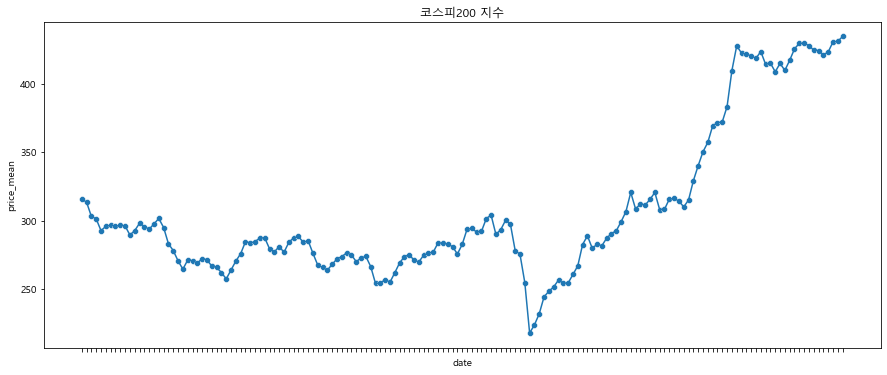

In [101]:
plt.figure(figsize=(15,6)) # 그림 크기
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.title("코스피200 지수")
g1_1=sns.scatterplot(data=df_KPI200_week, x='date', y="price_mean", legend=False )
g1_1.set(xticklabels=[])  # remove the tick labels  # add a title
g1_2=sns.lineplot(data=df_KPI200_week, x='date', y="price_mean")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


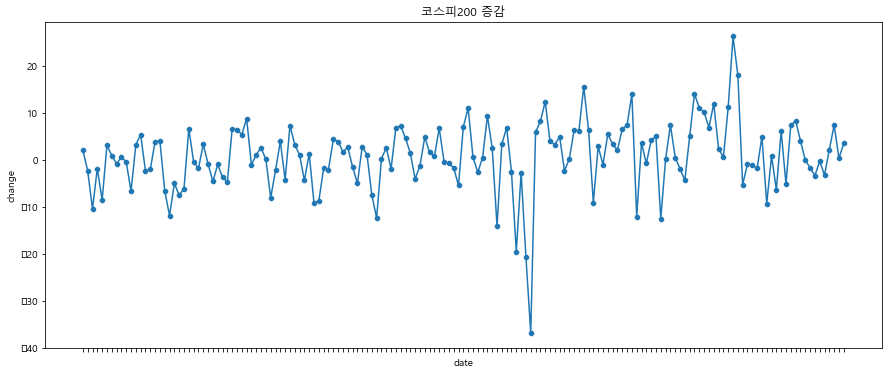

In [102]:
plt.figure(figsize=(15,6)) # 그림 크기
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.title("코스피200 증감")
g1_1=sns.scatterplot(data=df_KPI200_week, x='date', y="change", legend=False )
g1_1.set(xticklabels=[])  # remove the tick labels  # add a title
g1_2=sns.lineplot(data=df_KPI200_week, x='date', y="change")

### 저장

In [99]:
df_KPI200.to_csv('csv/KPI200/KPI200.csv', encoding = 'utf-8-sig', index = False)
df_KPI200_week.to_csv('csv/KPI200/KPI200_week.csv', encoding = 'utf-8-sig', index = False)
df_date_info.to_csv('csv/date_info/date_info.csv', encoding = 'utf-8-sig', index = False)